### European wholesale electricity price data
https://ember-climate.org/data-catalogue/european-wholesale-electricity-price-data/

In [4]:
import warnings
warnings.filterwarnings('ignore')
import requests, io
import pandas as pd
url = 'https://ember-climate.org/app/uploads/2022/09/european_wholesale_electricity_price_data_monthly-5.csv'
df = pd.read_csv(io.StringIO(requests.get(url).text))
df = df[df.Country == 'France'].drop(columns=['Country','ISO3 Code']).rename(columns={'Price (EUR/MWhe)':'Price'}).set_index('Date')
df.index = pd.date_range(df.index.min(), periods=len(df), freq="M")
df.T

,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30
Price,41.95,50.14,43.79,39.52,26.46,32.16,37.91,32.19,37.45,44.96,...,400.95,492.99,393.55,178.89,192.16,270.49,132.28,148.78,111.81,106.45


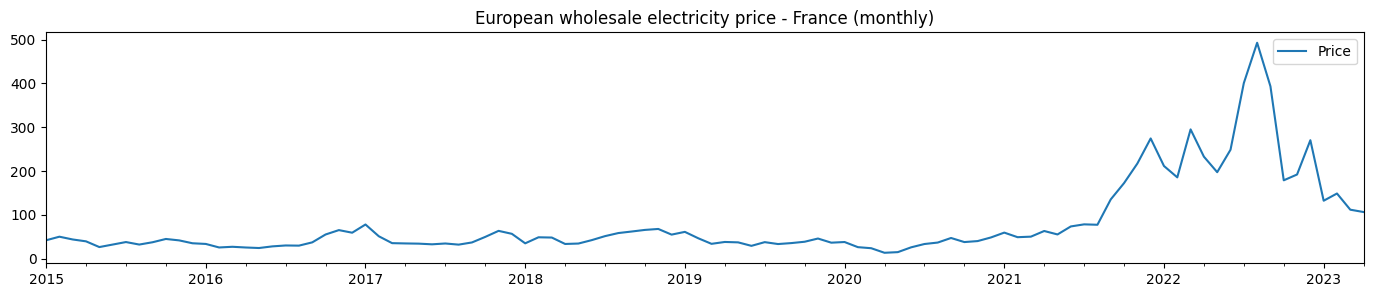

In [2]:
df.plot(figsize=(17,3), title='European wholesale electricity price - France (monthly)');

### Forecast from 2021-09-30

#### Train and Test split

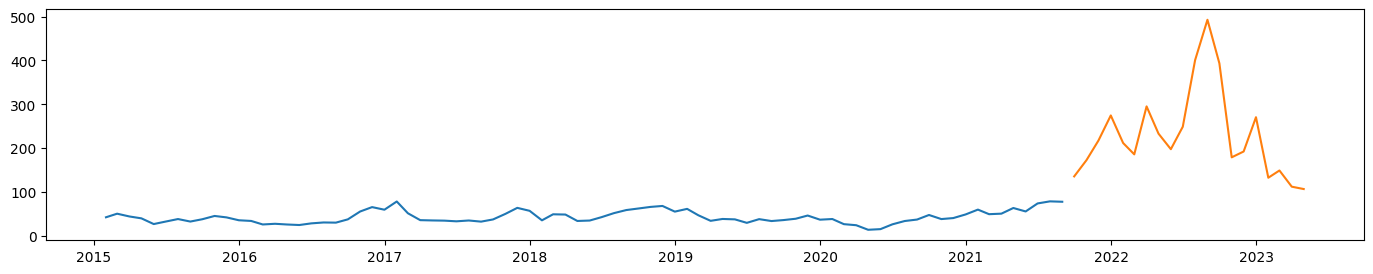

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,3))
train = df.loc[:'2021-08-31']
test = df.loc['2021-09-30':]
plt.plot(train)
plt.plot(test);

#### PACF

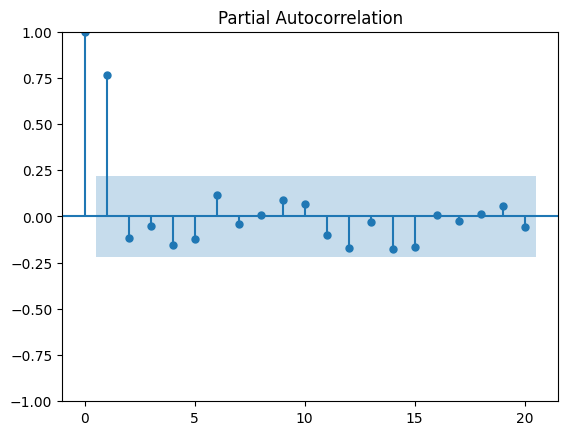

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(train);

#### KPSS test

So we fail to reject the Null hypothesis of non-stationarity with alpha